In [45]:
def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

{0: 0, 1: 1, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 17, 16: 18, 17: 19, 18: 20, 19: 21, 20: 22, 21: 23, 22: 25, 23: 26, 24: 27, 25: 28, 26: 30, 27: 31, 28: 33, 29: 34, 30: 35, 31: 36, 32: 37, 33: 38, 34: 39, 35: 40, 36: 41, 37: 42, 38: 44, 39: 45, 40: 47, 41: 48, 42: 49, 43: 51, 44: 53, 45: 52, 46: 54, 47: 55, 48: 50, 49: 57, 50: 56, 51: 58, 52: 59, 53: 60, 54: 61, 55: 62, 56: 63, 57: 64, 58: 65, 59: 66, 60: 67, 61: 68, 62: 69, 63: 70, 64: 71, 65: 72, 66: 73, 67: 74, 68: 75, 69: 76, 70: 77, 71: 78, 72: 79, 73: 80, 74: 81, 75: 82, 76: 83, 77: 84, 78: 86, 79: 87, 80: 85, 81: 88, 82: 89, 83: 90, 84: 92, 85: 93, 86: 91, 87: 94, 88: 95, 89: 96, 90: 98, 91: 99, 92: 100, 93: 101, 94: 102, 95: 103, 96: 104, 97: 105, 98: 106, 99: 107, 100: 108, 101: 109, 102: 110, 103: 111, 104: 113, 105: 114, 106: 115, 107: 116, 108: 112, 109: 117, 110: 118, 111: 119, 112: 120, 113: 121, 114: 122, 115: 123, 116: 124, 117: 125, 118: 126, 119: 127, 120: 129, 

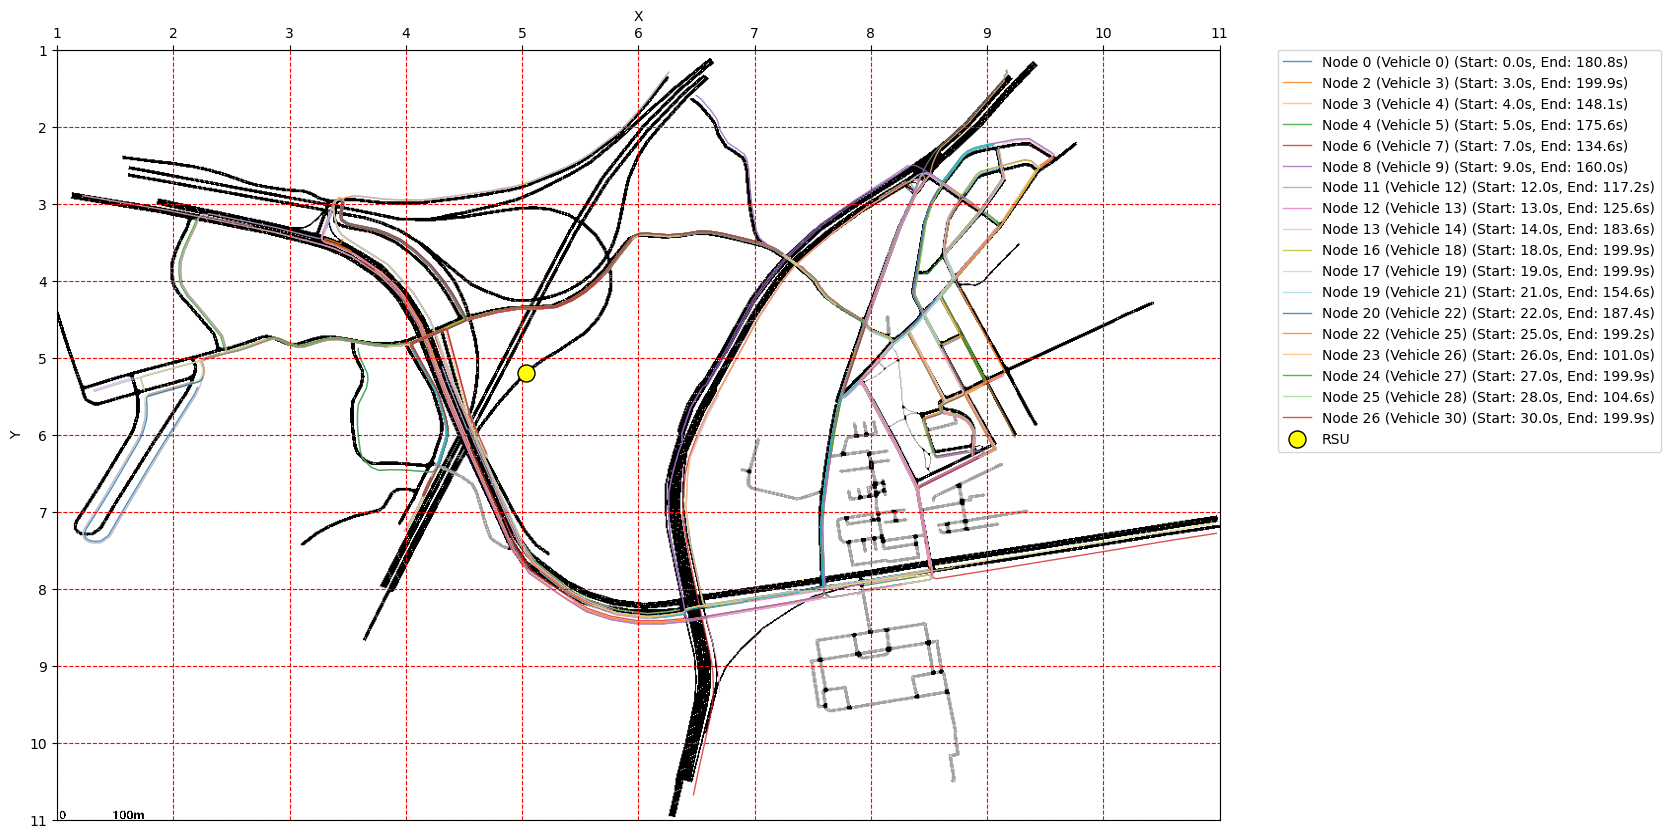

In [78]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET
from collections import defaultdict
import matplotlib.patheffects as path_effects
from matplotlib.ticker import FixedFormatter, FixedLocator

def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

def extract_data_from_xml(file_path, map_width=2200, map_height=1650, grid_size=10, time_limit=100.0, target_vehicle_ids=None):
    tree = ET.parse(file_path)
    root = tree.getroot()

    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if time > time_limit:
            break 
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            
            if target_vehicle_ids is not None and vehicle_id not in target_vehicle_ids:
                continue

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            speed = float(vehicle.get('speed'))

            grid_x = int(x / (map_width / grid_size))
            grid_y = int(y / (map_height / grid_size))

            extracted_data.append((time, vehicle_id, x, y, speed, grid_x, grid_y))

    columns = ['time', 'vehicle_id', 'x', 'y', 'speed', 'grid_x', 'grid_y']
    df = pd.DataFrame(extracted_data, columns=columns)
    return df


def calculate_grid_metric(data, grid_size, map_width, map_height):
    grid_metric = defaultdict(list)
    for _, row in data.iterrows():
        grid_x = row['grid_x']
        grid_y = row['grid_y']

        grid_metric[(grid_x, grid_y)].append(row['vehicle_id'])

    grid_avg_metric = {}
    for (grid_x, grid_y), vehicle_counts in grid_metric.items():
        avg_vehicles = len(vehicle_counts) / len(data['time'].unique())
        grid_avg_metric[(grid_x, grid_y)] = avg_vehicles

    return grid_avg_metric

def plot_data(data, node_to_vehicle_map, map_width=2180, map_height=1500, grid_size=10):
    grid_avg_metric = calculate_grid_metric(data, grid_size, map_width, map_height)

    plt.figure(figsize=(15, 10))
    bg_img = mpimg.imread('background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)
    unique_vehicle_ids = data['vehicle_id'].unique()

    
    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx in range(len(unique_vehicle_ids))]  # 색상 수를 초과하지 않도록 설정
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    # 각 차량별로 궤적과 시작/종료 시간을 그리기
    for vehicle_id in unique_vehicle_ids:
        vehicle_data = data[data['vehicle_id'] == vehicle_id]
        node_id = list(node_to_vehicle_map.keys())[list(node_to_vehicle_map.values()).index(vehicle_id)]
        
        # 차량의 시작 시간과 종료 시간 계산
        start_time = vehicle_data['time'].min()
        end_time = vehicle_data['time'].max()

        # 궤적 그리기
        if start_time <= 30 and end_time >= 100:
            plt.plot(
                vehicle_data['x'] + 15 , vehicle_data['y'] - 1160, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=1, 
                label=f'Node {node_id} (Vehicle {vehicle_id}) (Start: {start_time:.1f}s, End: {end_time:.1f}s)', 
                zorder=1
            )
        else:
            plt.plot(
                vehicle_data['x'] + 15 , vehicle_data['y'] - 1160, 
                color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=1, 
                zorder=1
            )


        # 차량의 시작 지점을 강조 표시
        #starting_position = vehicle_data.iloc[0]
        #plt.scatter(starting_position['x'] + 20, starting_position['y'] - 1050, c=[vehicle_colors[vehicle_id]], alpha=0.8, linewidth=5, marker='o', zorder=2)

        # 차량의 ID를 텍스트로 표시
        #plt.text(
        #    starting_position['x'] + 20, starting_position['y'] - 1050, str(node_id),
        #    fontsize=13, color='red', fontweight='bold', ha='right', va='bottom', zorder=3
        #)

    plt.xlabel("X")
    plt.ylabel("Y")

    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    plt.scatter(map_width - 1300, 870, color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
    #plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.show()


def main():
    node_table = load_node_table('node_table_low.txt')
    
    print(node_table)
    
    target_node_ids = [i for i in range(0, 161)]

    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]
    
    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}
    
    data = extract_data_from_xml('map0.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)
    plot_data(data, node_to_vehicle_map)

if __name__ == "__main__":
    main()


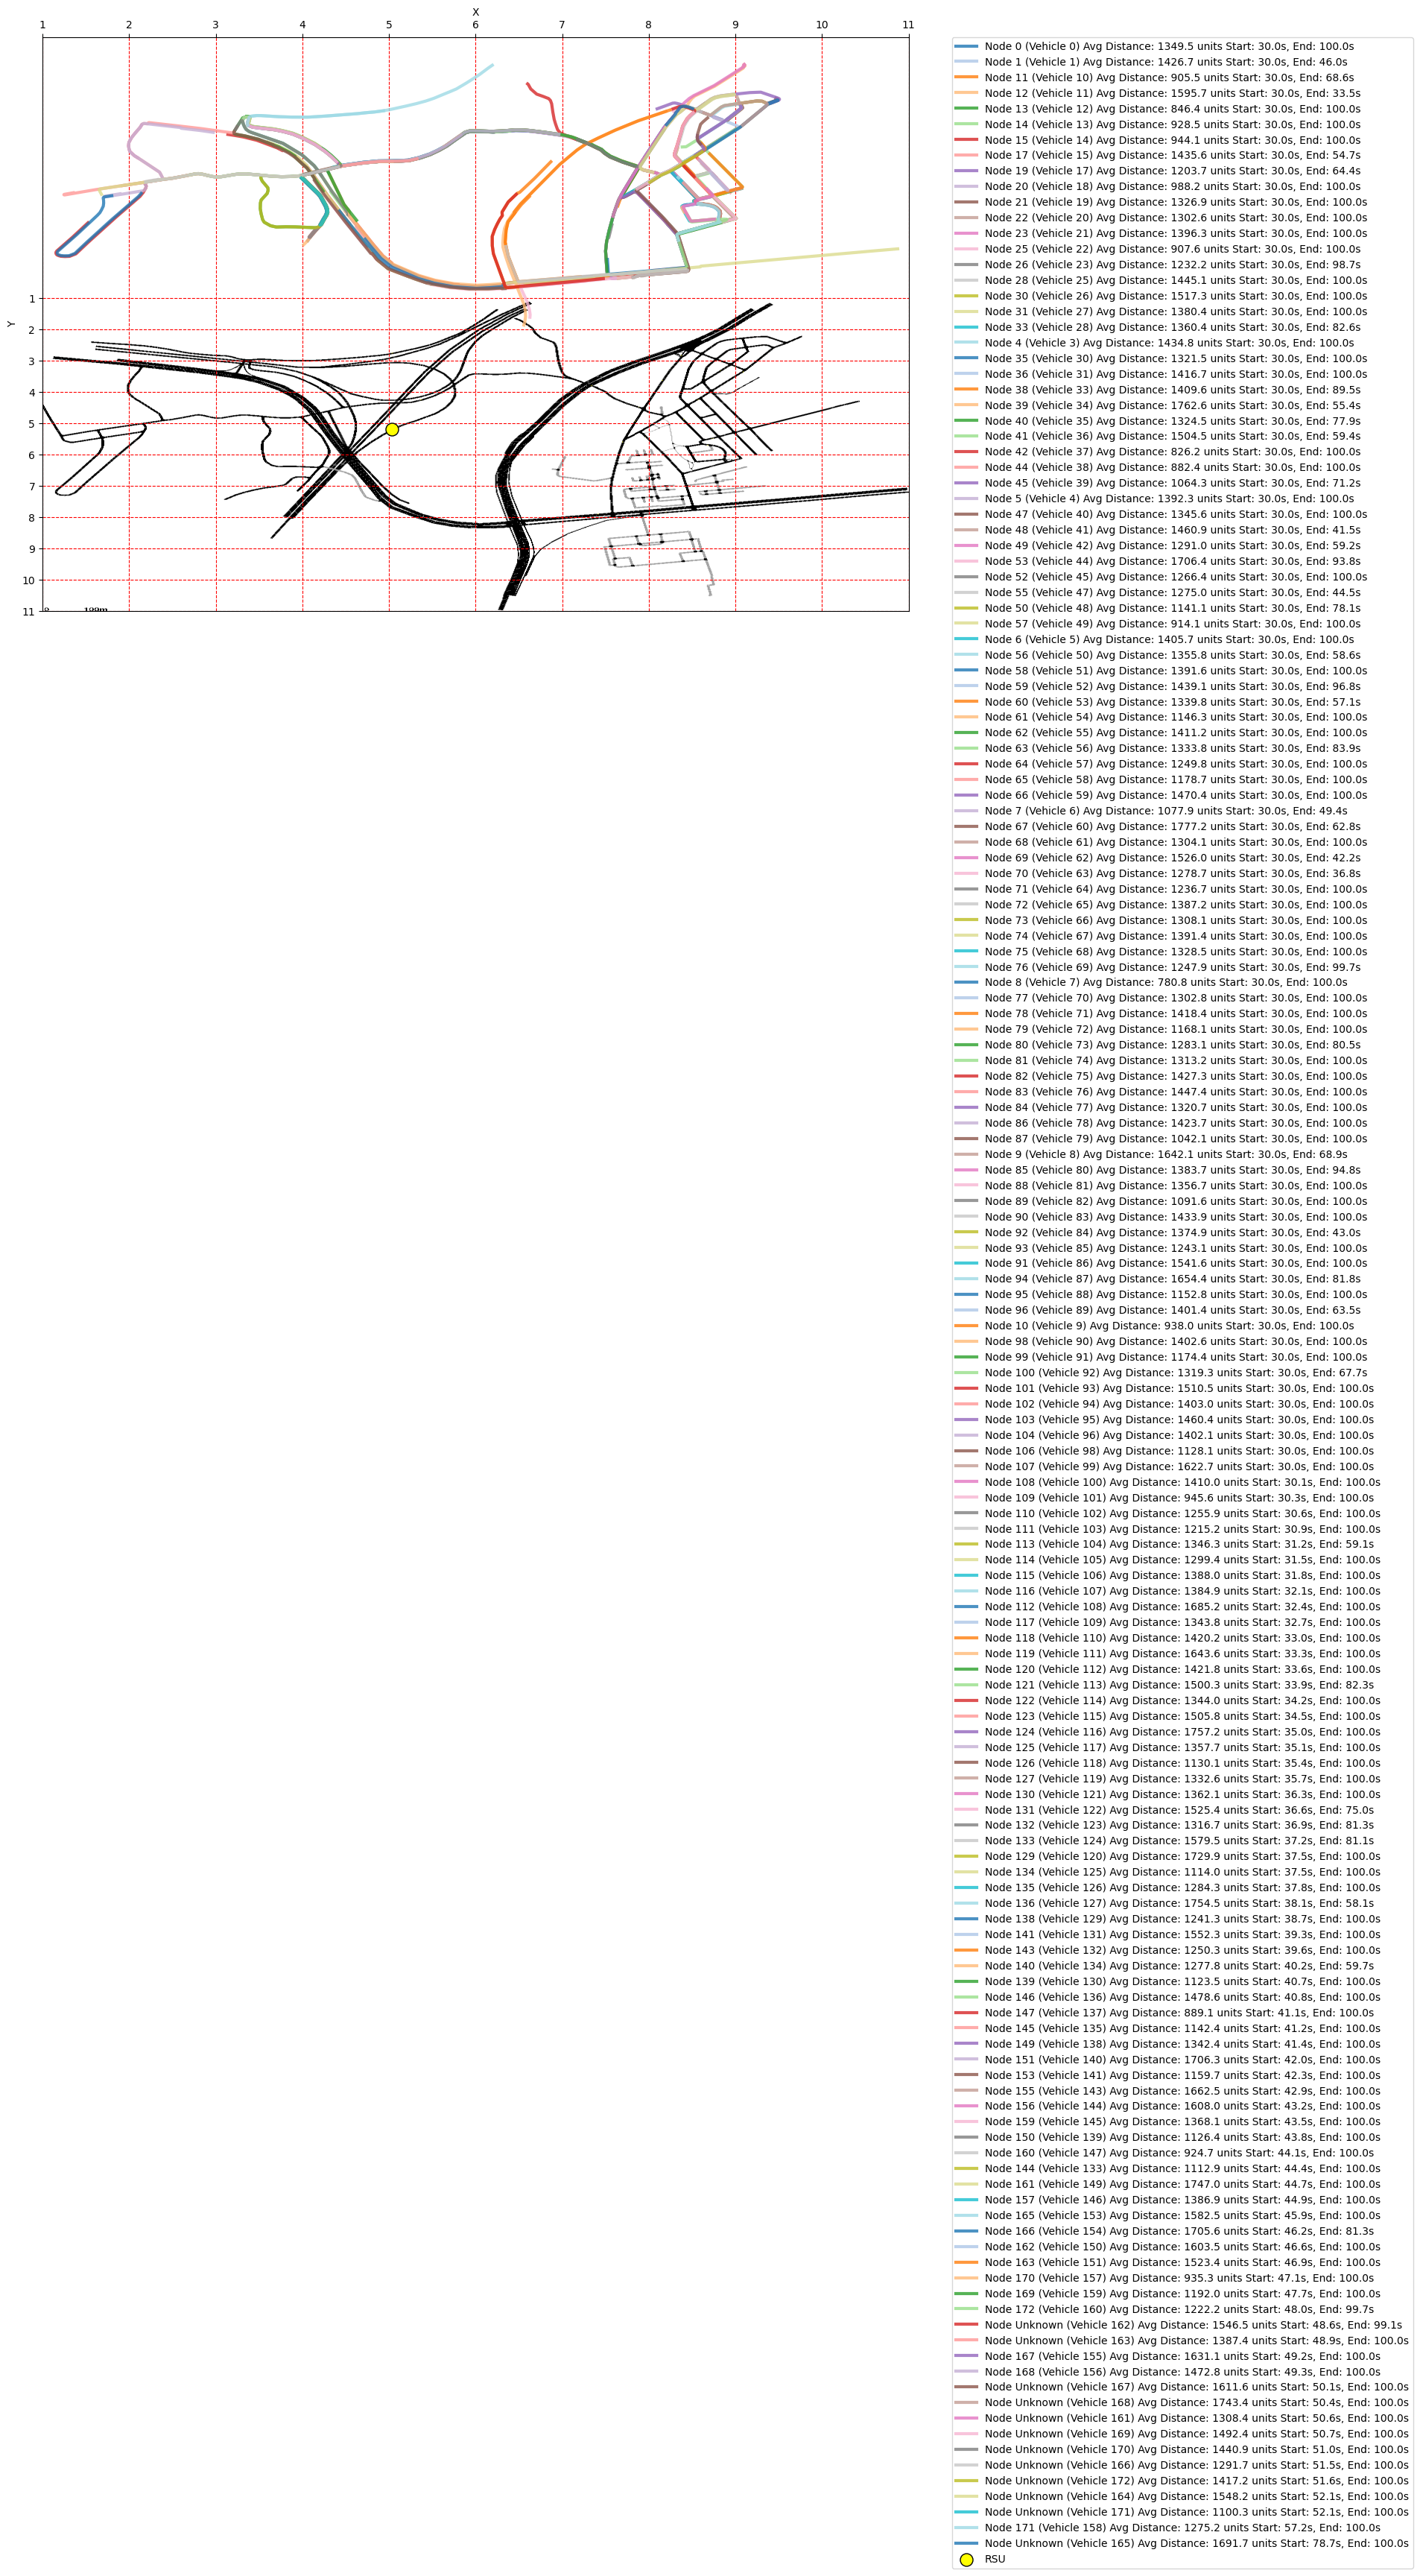

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FixedLocator, FixedFormatter

def calculate_avg_distances_to_rsu(data, rsu_position, start_time, end_time):
    avg_distances = {}
    
    filtered_data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

    for vehicle_id in filtered_data['vehicle_id'].unique():
        vehicle_data = filtered_data[filtered_data['vehicle_id'] == vehicle_id]
        
        distances = np.sqrt(
            (vehicle_data['x'] - rsu_position[0])**2 +
            (vehicle_data['y'] - rsu_position[1])**2
        )
        avg_distance = distances.mean()
        avg_distances[vehicle_id] = avg_distance
    
    return avg_distances

def plot_data(data, node_to_vehicle_map, map_width=2180, map_height=1500, grid_size=10, start_time=30, end_time=100):
    rsu_position = (map_width - 1300, 870)

    # 30초 ~ 100초 범위의 데이터만 필터링
    filtered_data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

    if filtered_data.empty:
        print(f"No data available between {start_time}s and {end_time}s.")
        return

    # 평균 거리 계산
    avg_distances = calculate_avg_distances_to_rsu(data, rsu_position, start_time, end_time)

    plt.figure(figsize=(15, 10))
    bg_img = mpimg.imread('background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)

    unique_vehicle_ids = filtered_data['vehicle_id'].unique()
    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx, vehicle_id in enumerate(unique_vehicle_ids)]
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    for vehicle_id in unique_vehicle_ids:
        vehicle_data = filtered_data[filtered_data['vehicle_id'] == vehicle_id]
        if vehicle_data.empty:
            continue

        # 차량의 실제 시간 범위 계산
        actual_start_time = vehicle_data['time'].min()
        actual_end_time = vehicle_data['time'].max()

        # 시간 조건을 완전히 만족하지 않는 차량 제외
        if actual_start_time > end_time or actual_end_time < start_time:
            continue

        # 차량에 대한 노드 ID 찾기
        node_id = node_to_vehicle_map.get(vehicle_id, "Unknown")
        avg_distance = avg_distances.get(vehicle_id, 0)

        # 궤적 시각화
        plt.plot(
            vehicle_data['x'], vehicle_data['y'],
            color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=3,
            label=(f"Node {node_id} (Vehicle {vehicle_id}) "
                   f"Avg Distance: {avg_distance:.1f} units "
                   f"Start: {actual_start_time:.1f}s, End: {actual_end_time:.1f}s")
        )

    # RSU 위치 표시
    plt.scatter(rsu_position[0], rsu_position[1], color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
    plt.xlabel("X")
    plt.ylabel("Y")

    # 그래프 그리드 및 축 설정
    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()


def main():
    node_table = load_node_table('node_table_low.txt')
    target_node_ids = [i for i in range(0, 161)]
    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]
    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}

    data = extract_data_from_xml('map2.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)

    plot_data(data, node_to_vehicle_map, start_time=30, end_time=100)

if __name__ == "__main__":
    main()


       time  vehicle_id        x        y  speed  grid_x  grid_y
3472   80.0          12  1172.21  1549.85   8.98       5       9
3473   80.0          13   823.54  1769.64  20.27       3      10
3474   80.0          14   989.36  1564.41  21.83       4       9
3475   80.0          18  1394.99  1605.45  11.61       6       9
3476   80.0           9  1281.30  1569.40  19.29       5       9
...     ...         ...      ...      ...    ...     ...     ...
4472  100.0          12  1421.95  1597.50   3.53       6       9
4473  100.0          13   675.51  2148.58  20.27       3      13
4474  100.0          14  1223.83  1559.35  12.04       5       9
4475  100.0          18  1167.97  1567.80   5.88       5       9
4476  100.0           9  1421.97  1751.27  20.74       6      10

[1005 rows x 7 columns]


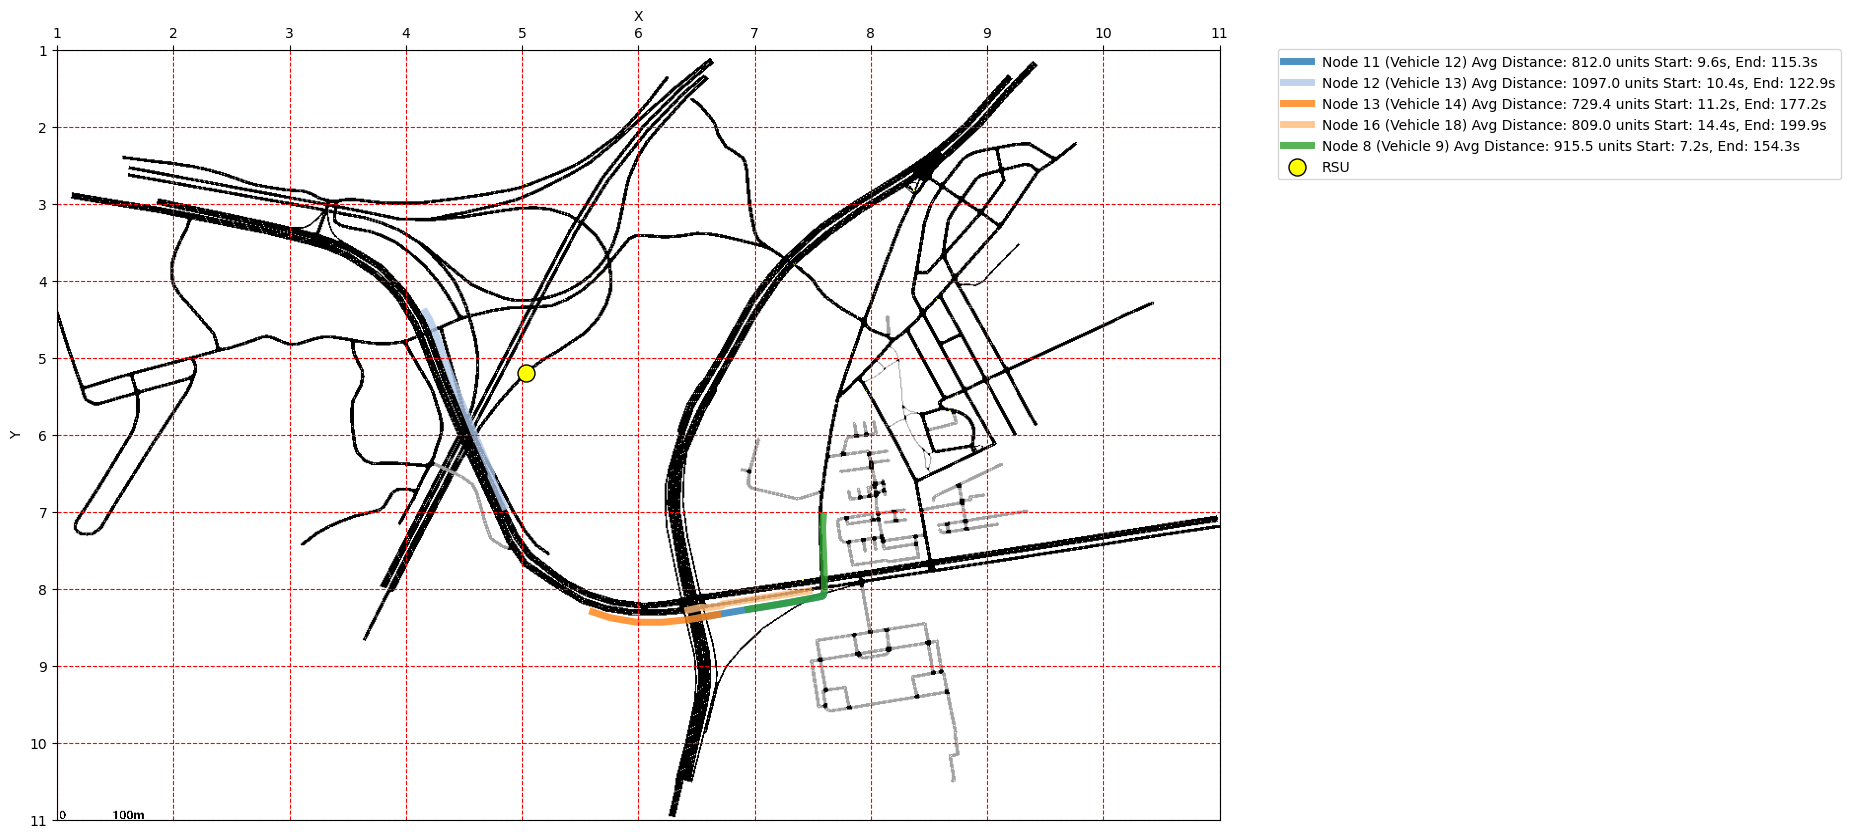

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FixedLocator, FixedFormatter

def load_node_table(file_path):
    node_map = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(':')
            node_index = int(parts[0].strip())
            node_value = int(parts[1].strip())
            node_map[node_index] = node_value
    return node_map

def extract_data_from_xml(file_path, map_width=2200, map_height=1650, grid_size=10, time_limit=100.0, target_vehicle_ids=None):
    import xml.etree.ElementTree as ET
    tree = ET.parse(file_path)
    root = tree.getroot()

    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if time > time_limit:
            break 
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            
            if target_vehicle_ids is not None and vehicle_id not in target_vehicle_ids:
                continue

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            speed = float(vehicle.get('speed'))

            grid_x = int(x / (map_width / grid_size))
            grid_y = int(y / (map_height / grid_size))

            extracted_data.append((time, vehicle_id, x, y, speed, grid_x, grid_y))

    columns = ['time', 'vehicle_id', 'x', 'y', 'speed', 'grid_x', 'grid_y']
    df = pd.DataFrame(extracted_data, columns=columns)
    return df

def calculate_avg_distances_to_rsu(data, rsu_position, start_time, end_time):
    avg_distances = {}
    
    # 시간 범위 필터링
    filtered_data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]
    print(filtered_data)

    for vehicle_id in filtered_data['vehicle_id'].unique():
        vehicle_data = filtered_data[filtered_data['vehicle_id'] == vehicle_id]
        
        distances = np.sqrt(
            (vehicle_data['x'] - rsu_position[0])**2 +
            (vehicle_data['y'] - rsu_position[1])**2
        )
        avg_distance = distances.mean()
        avg_distances[vehicle_id] = avg_distance
    
    return avg_distances

def plot_data(data, node_to_vehicle_map, map_width=2180, map_height=1500, grid_size=10, start_time=30, end_time=100):
    rsu_position = (map_width - 1300, 870)
    
    # 시간 필터링
    filtered_data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

    if filtered_data.empty:
        print(f"No data available between {start_time}s and {end_time}s.")
        return

    # RSU와 차량 평균 거리 계산
    avg_distances = calculate_avg_distances_to_rsu(data, rsu_position, start_time, end_time)

    # 맵 시각화 설정
    plt.figure(figsize=(15, 10))
    bg_img = mpimg.imread('background.png')
    ax = plt.gca()
    extent = [0, map_width, 0, map_height]
    ax.imshow(bg_img, aspect='auto', extent=extent, zorder=0)

    # 차량 궤적 색상 설정
    unique_vehicle_ids = filtered_data['vehicle_id'].unique()
    cmap = plt.colormaps['tab20']
    colors = [cmap(idx % cmap.N) for idx in range(len(unique_vehicle_ids))]
    vehicle_colors = {vehicle_id: colors[idx] for idx, vehicle_id in enumerate(unique_vehicle_ids)}

    # 차량별로 궤적 그리기
    for vehicle_id in unique_vehicle_ids:
        vehicle_data = filtered_data[filtered_data['vehicle_id'] == vehicle_id]
        if vehicle_data.empty:
            continue

        # 차량의 실제 시작 및 종료 시간 계산 (전체 데이터에서)
        actual_start_time = data[data['vehicle_id'] == vehicle_id]['time'].min()
        actual_end_time = data[data['vehicle_id'] == vehicle_id]['time'].max()

        # 궤적과 정보 표시
        node_id = list(node_to_vehicle_map.keys())[list(node_to_vehicle_map.values()).index(vehicle_id)]
        avg_distance = avg_distances.get(vehicle_id, 0)

        plt.plot(
            vehicle_data['x'] + 15, vehicle_data['y'] - 1160,
            color=vehicle_colors[vehicle_id], alpha=0.8, linewidth=5,
            label=(
                f"Node {node_id} (Vehicle {vehicle_id}) "
                f"Avg Distance: {avg_distance:.1f} units "
                f"Start: {actual_start_time:.1f}s, End: {actual_end_time:.1f}s"
            ),
            zorder=1
        )

    # RSU 표시
    plt.scatter(rsu_position[0], rsu_position[1], color='yellow', s=150, edgecolors='black', label='RSU', zorder=4)
    plt.xlabel("X")
    plt.ylabel("Y")

    # 그리드 설정
    ax.set_xticks(np.arange(0, map_width, map_width // grid_size))
    ax.set_yticks(np.arange(0, map_height, map_height // grid_size))
    ax.grid(which='both', color='red', linestyle='--', linewidth=0.8)

    # 축 레이블 설정
    x_labels = np.linspace(0, map_width, grid_size + 1)
    y_labels = np.linspace(0, map_height, grid_size + 1)
    ax.xaxis.set_major_locator(FixedLocator(x_labels))
    ax.yaxis.set_major_locator(FixedLocator(y_labels))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)]))
    ax.yaxis.set_major_formatter(FixedFormatter([str(i) for i in range(1, grid_size + 2)][::-1]))
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    # 범례 표시
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

def main():
    node_table = load_node_table('node_table_low.txt')
    target_node_ids = [8, 11, 12, 13, 16]
    target_vehicle_ids = [node_table[node_id] for node_id in target_node_ids if node_id in node_table]
    node_to_vehicle_map = {node_id: node_table[node_id] for node_id in target_node_ids if node_id in node_table}

    # 데이터 추출
    data = extract_data_from_xml('map1.xml', time_limit=200.0, target_vehicle_ids=target_vehicle_ids)

    # 시각화 함수 호출
    plot_data(data, node_to_vehicle_map, start_time=80, end_time=100)

if __name__ == "__main__":
    main()


In [70]:
def remove_duplicates_from_file(input_file, output_file):
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    seen = set()
    unique_lines = []
    
    for line in lines:
        if line not in seen:
            unique_lines.append(line)
            seen.add(line)
    
    with open(output_file, 'w') as file:
        file.writelines(unique_lines)

input_file = 'external_id_table_high.txt'
output_file = 'node_table_high.txt'

remove_duplicates_from_file(input_file, output_file)